In [437]:
import pandas as pd
import numpy as np
from sqlalchemy import engine

In [438]:
conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [442]:
query = """select * from mat_orders"""

df = pd.read_sql(query, con=conn_string)

In [443]:
cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    AND created_at < '2023-07-01'
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

In [445]:
filtered_df.shape

(22696, 41)

In [446]:
filtered_df.describe()

,final_price,discounted_amount,final_price_usd,discounted_amount_usd,original_price_usd,processing_fee_in_usd,to_usd_rate,add_on_days_to_expire,capacity,quantity
count,22696.000000,22696.000000,22696.000000,22696.000000,22696.000000,22696.000000,22696.000000,2947.000000,19721.000000,22689.000000
mean,198.785689,9.704338,105.170612,4.921934,110.092546,2.812723,0.832471,48.079403,2.953349,1.184407
std,364.415894,71.270400,149.030612,31.483565,158.303201,4.214111,0.352630,23.687756,25.872057,0.699475
min,0.640000,0.000000,0.680000,0.000000,13.690000,0.000000,0.198240,30.000000,1.000000,1.000000
25%,35.000000,0.000000,34.800000,0.000000,35.000000,1.200000,0.307469,30.000000,1.000000,1.000000
50%,70.000000,0.000000,47.860000,0.000000,49.565000,1.610000,1.000000,30.000000,1.000000,1.000000
75%,175.500000,0.000000,117.700000,0.000000,120.000000,3.020000,1.043048,60.000000,1.000000,1.000000
max,9009.000000,3715.000000,3125.000000,1057.510000,3200.000000,116.300000,1.405630,180.000000,1000.000000,20.000000


In [448]:
filtered_df['created_at'].count()

22696

In [449]:
# Extracting just the date from created_at as date
filtered_df['date'] = filtered_df['created_at'].dt.date

filtered_df['date'].count()

22696

In [450]:
filtered_df['date'].value_counts()

2023-06-21    100
2023-06-12     92
2023-04-17     91
2023-01-18     89
2023-06-26     88
             ... 
2021-06-26      1
2021-05-22      1
2021-04-28      1
2021-04-02      1
2021-12-25      1
Name: date, Length: 821, dtype: int64

In [451]:
filtered_df['date'].describe()

count          22696
unique           821
top       2023-06-21
freq             100
Name: date, dtype: object

In [453]:
filtered_df.head()

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,...,booking_product_type,product_type_id,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh
0,464fcc76-0e2a-41d3-be92-ee39e4e0cfce,bb20bb49-ad53-4ab3-875b-3c523360ac46,The Yard,paid,WL,Leila Nashed,lnashed@tulane.edu,Leila Nashed,1da944cc,cb1fd9eb-21f5-403c-bc28-2479c2acd4cd,...,entire_location,abdad414-c692-40a9-aa55-dd41ac11f252,NaN,1.0,0423f869-9da2-4d8f-89fe-5d79dc67d008,2022-11-17,2022-11-17,2022-11-16,1.0,2023-07-18 19:45:00.075106+00:00
1,127566a9-d3e9-41b3-a4b7-23fc53827db8,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Deni Panknin,deni.panknin@blueapes.de,Blue Apes Consulting GmbH,e86aa323,0fdf4261-06ee-4c88-aa94-4360a91eb453,...,entire_location,bef677a6-5596-4ca0-a31e-ea2eccb5e959,NaN,1.0,35333e21-eaad-410c-bfd3-88dcad4675be,2022-06-28,2022-06-30,2022-06-24,3.0,2023-07-18 19:45:00.075106+00:00
2,119e7b1e-8370-40b8-ad76-aafa7ce29f5d,b2d12ba7-c1f8-403c-9514-96017a99bd46,The Malin,paid,WL,Lauren M Teng,earthtoteng@gmail.com,YouTube,a9dd16e8,f12b24e8-f18b-401b-954d-f20f0cdb2b4d,...,meeting_room,5ca0df59-cc84-4ab5-a338-50a926655b4e,NaN,20.0,48931c1f-bde3-4335-ad2e-d881360b5552,None,None,2022-09-07,1.0,2023-07-18 19:45:00.075106+00:00
3,8e79204e-8577-4a46-a966-e6a6c78aee7e,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Magnus Drewelies,magnus.drewelies@gmail.com,MD8 Holding UG,52442902,3299dac1-0380-448e-8b8b-07393fbef811,...,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,30.0,NaN,None,None,None,2021-11-04,1.0,2023-07-18 19:45:00.075106+00:00
4,f4d3f3f4-4d68-495e-a32d-a9da7074e71e,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Marc Tuduri,marctc@pm.me,Grafana,59589bee,a799d215-583a-495c-bb0e-7940ede0c38c,...,entire_location,bef677a6-5596-4ca0-a31e-ea2eccb5e959,NaN,1.0,b870fc5b-340a-4e32-ae63-e52d1b6275fa,2022-08-24,2022-08-24,2022-08-24,1.0,2023-07-18 19:45:00.075106+00:00


In [454]:
filtered_df['operator_id'].nunique()

21

In [455]:
filtered_df['operator_name'].nunique()

21

In [456]:
filtered_df['operator_name'].count()

22696

In [457]:
filtered_df['order_id'].count()

22696

In [458]:
filtered_df.dtypes

order_id                                object
operator_id                             object
operator_name                           object
status                                  object
source                                  object
fullname                                object
customer_email                          object
company_name                            object
confirmation_id                         object
space_id                                object
space_name                              object
created_at                      datetime64[ns]
promotion_code                          object
final_price                            float64
discounted_amount                      float64
final_price_usd                        float64
discounted_amount_usd                  float64
original_price_usd                     float64
processing_fee_in_usd                  float64
to_usd_rate                            float64
location_id                             object
location_name

In [459]:
filtered_df.isnull().sum()

order_id                       0
operator_id                    0
operator_name                  0
status                         0
source                         0
fullname                       0
customer_email                 0
company_name                   0
confirmation_id                0
space_id                       7
space_name                     7
created_at                     0
promotion_code             16374
final_price                    0
discounted_amount              0
final_price_usd                0
discounted_amount_usd          0
original_price_usd             0
processing_fee_in_usd          0
to_usd_rate                    0
location_id                    7
location_name_en               7
location_time_zone             7
country                        7
state                      13668
city                           7
order_line_item_id             7
orderable_type                 7
orderable_id                   7
order_line_item_details      769
access_id 

In [460]:
filtered_df.describe(include='all', datetime_is_numeric=True)

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,...,booking_product_type,product_type_id,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh
count,22696,22696,22696,22696,22696,22696,22696,22696,22696,22689,...,22689,22689,2947.000000,19721.000000,19721,16645,16645,22696,22689.000000,22696
unique,22696,21,21,1,2,14374,14068,13071,22696,595,...,5,79,NaN,NaN,19721,756,755,821,NaN,NaN
top,464fcc76-0e2a-41d3-be92-ee39e4e0cfce,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Sharon Grossman,sgrossman@augury.com,N/A,1da944cc,3299dac1-0380-448e-8b8b-07393fbef811,...,entire_location,bef677a6-5596-4ca0-a31e-ea2eccb5e959,NaN,NaN,0423f869-9da2-4d8f-89fe-5d79dc67d008,2023-02-08,2023-02-08,2023-06-21,NaN,NaN
freq,1,9131,9131,22696,22573,73,80,216,1,919,...,15389,7004,NaN,NaN,1,78,76,100,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,48.079403,2.953349,NaN,NaN,NaN,NaN,1.184407,2023-07-18 19:45:00.075106048+00:00
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,2023-07-18 19:45:00.075106+00:00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,2023-07-18 19:45:00.075106048+00:00
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,2023-07-18 19:45:00.075106048+00:00
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,60.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,2023-07-18 19:45:00.075106048+00:00
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,180.000000,1000.000000,NaN,NaN,NaN,NaN,20.000000,2023-07-18 19:45:00.075106+00:00


In [461]:
# number of customers as email
filtered_df['customer_email'].nunique()

14068

In [462]:
filtered_df['company_name'].nunique()

13071

In [464]:
# Counting the number of unique countries
filtered_df['country'].nunique()

7

In [465]:
# Counting the number of unique states
filtered_df['state'].nunique()

9

In [466]:
# Coutning the number of unique cities
filtered_df['city'].nunique()

40

In [467]:
fdf = filtered_df

# Exploring features to measure success

In [468]:
import matplotlib.pyplot as plt
import seaborn as sns

In [469]:
country_totals = pd.DataFrame(fdf.groupby('country', as_index = False)['final_price_usd'].sum())

In [470]:
country_totals = country_totals.sort_values(by='final_price_usd', ascending=False).reset_index(drop=True)

In [471]:
country_totals

,country,final_price_usd
0,US,943613.29
1,IL,834944.20
2,DE,349554.18
3,GB,129586.27
4,NL,63906.57
5,PL,38514.04
6,RO,25045.77


Text(0.5, 1.0, 'Country Monetary Value')

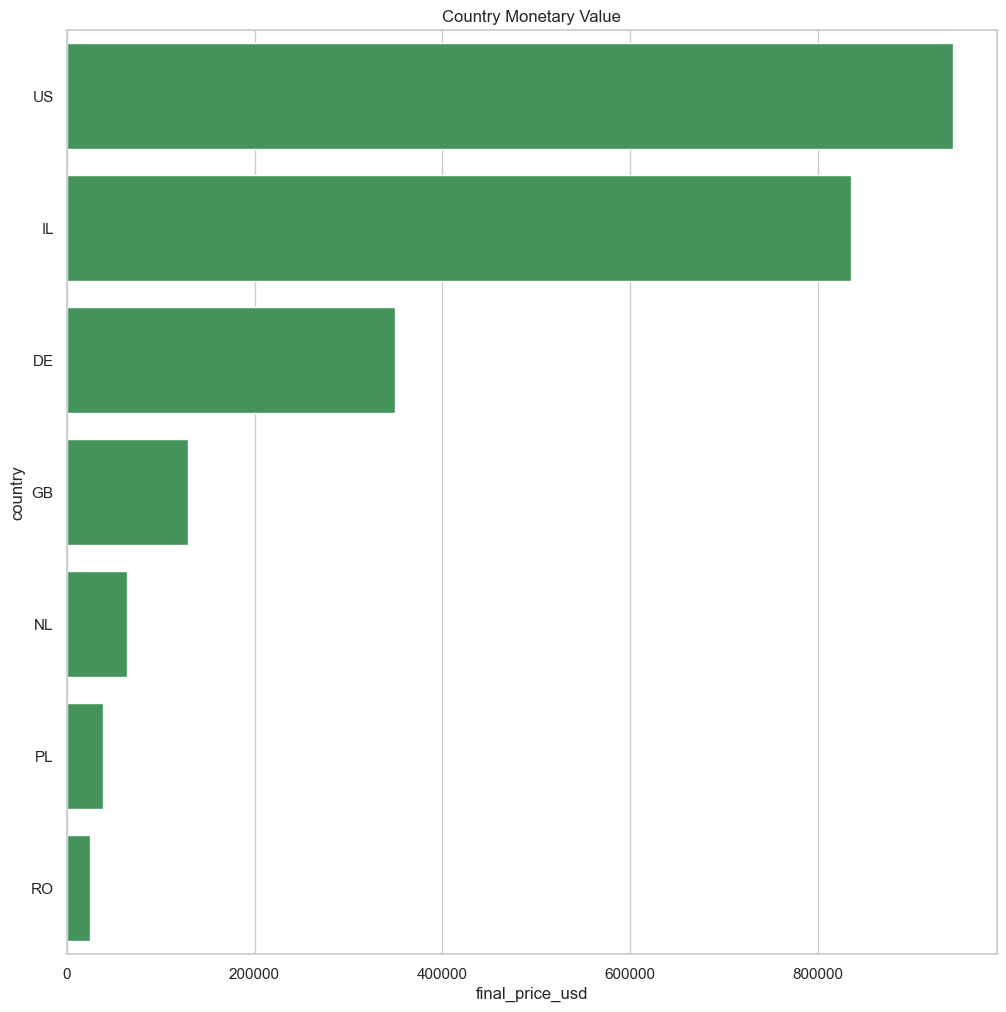

In [472]:
plt.figure(figsize = (12, 12))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Greens_d", 1)

sns.barplot(y = country_totals['country'], x = country_totals['final_price_usd'], palette= pal)

plt.title('Country Monetary Value')

The US has generated the most followed closely by Israel

In [473]:
country_operator = pd.DataFrame(fdf.groupby('country', as_index = False)['operator_name'].nunique()).sort_values(by='operator_name', ascending=False).reset_index(drop=True)
                                                                                                               

In [474]:
country_operator

,country,operator_name
0,US,16
1,IL,6
2,PL,2
3,DE,1
4,GB,1
5,NL,1
6,RO,1


Text(0.5, 1.0, 'Operators in each Country')

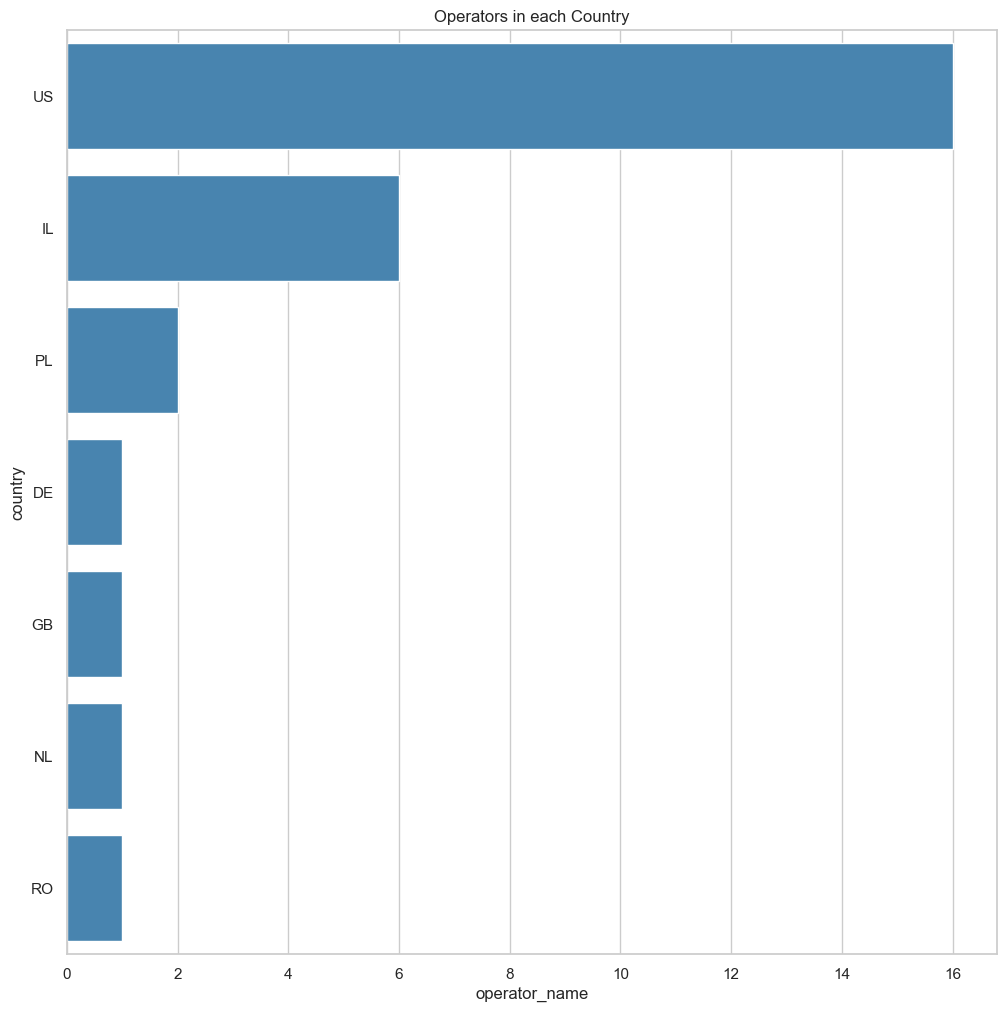

In [476]:
plt.figure(figsize = (12, 12))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Blues_d", 1)

sns.barplot(y = country_operator['country'], x = country_operator['operator_name'], palette= pal)

plt.title('Operators in each Country')

It seems a variety of operaters in a country positively correlates with higher revenues. 

In [478]:
pivot_table = fdf.groupby(['operator_name', 'country']).size().unstack(fill_value=0)

pivot_table


country,DE,GB,IL,NL,PL,RO,US
operator_name,,,,,,,
Bond Collective,0,0,0,0,0,0,377
Brain Embassy,0,0,103,0,502,0,0
Coalition Space,0,0,0,0,0,0,8
FoundrSpace,0,0,0,0,0,0,146
Luminary,0,0,0,0,0,0,785
M-Dot,0,0,101,0,0,0,0
Mindspace,4792,1211,514,947,68,288,1311
Nomadworks,0,0,0,0,0,0,932
Platform Coworking,0,0,0,0,0,0,16


Mindspace has a footprint in every country, the most being in Germany.

In [479]:
# Convert 'date' to a time stamp
fdf['date'] = pd.to_datetime(fdf['date'])

# Max date
fdf['date'].max()

Timestamp('2023-06-30 00:00:00')

In [480]:
# Min date
fdf['date'].min()

Timestamp('2021-03-10 00:00:00')

In [482]:
# Group by partner_name and get the first transaction date
first_trans_date = fdf.groupby('operator_name')['date'].min()

# Convert to DataFrame and reset index
first_trans_date = pd.DataFrame(first_trans_date).reset_index()


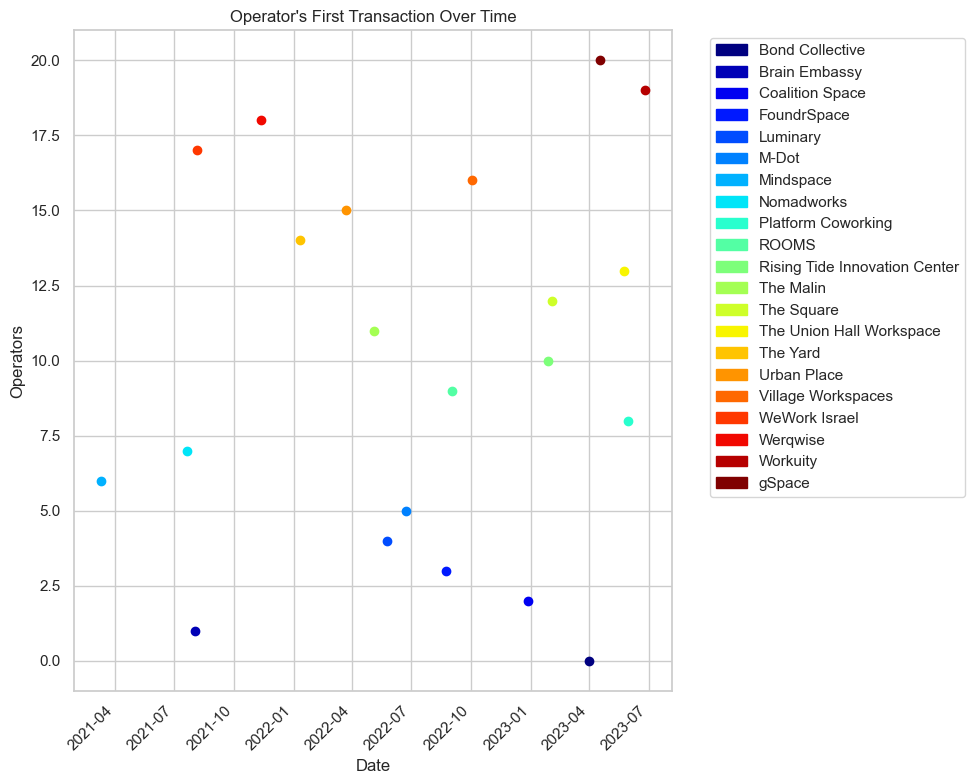

In [488]:
import matplotlib.patches as mpatches

# Create a numerical mapping for operator_name
first_trans_date['operator_num'] = first_trans_date['operator_name'].astype('category').cat.codes

plt.figure(figsize=(10, 8))
for i, operator in enumerate(first_trans_date['operator_name'].unique()):
    plt.scatter(first_trans_date.loc[first_trans_date['operator_name'] == operator, 'date'], 
                first_trans_date.loc[first_trans_date['operator_name'] == operator, 'operator_num'], 
                color = plt.cm.jet(i / 20),
                label=operator)

# create legend patches
legend_patches = [mpatches.Patch(color=plt.cm.jet(i / 20), label=operator) for i, operator in enumerate(first_trans_date['operator_name'].unique())]

# add the legend to the plot
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the chart title and axis labels
plt.title("Operator's First Transaction Over Time")
plt.xlabel('Date')
plt.ylabel('Operators')

# Set the x-tick labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


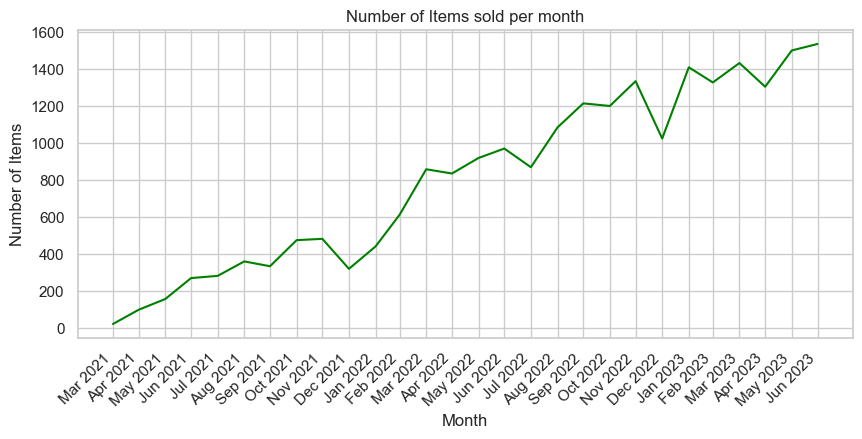

In [489]:
df_group = pd.DataFrame(fdf.resample('M', on='date')['order_id'].count())
df_group.columns = ['Number_of_items_sold']
    
plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group.index, y=df_group['Number_of_items_sold'], color = 'Green')

# Set the chart title and axis labels
plt.title('Number of Items sold per month')
plt.xlabel('Month')
plt.ylabel('Number of Items')

plt.xticks(df_group.index, df_group.index.strftime('%b %Y'), rotation=45, ha='right')
plt.show()

The number of sold products has been rising steadily with the expectation of dips withiin December as seen in 2021 and 2022.

In [492]:
operator_group = pd.DataFrame(fdf.groupby(['operator_name', 'order_id', 'date'], as_index = False )['final_price_usd'].sum())


In [493]:
operator_group.head()

,operator_name,order_id,date,final_price_usd
0,Bond Collective,0146c887-e3c3-4197-9688-9e87fdd97d5e,2023-05-24,300.0
1,Bond Collective,0293d38f-25cf-4911-8a94-c2aa1e996310,2023-05-18,1200.0
2,Bond Collective,031220b2-4bc2-4b0b-a9fc-29221d0eeee0,2023-04-17,300.0
3,Bond Collective,03e59b97-56da-457a-bdf3-a2084c97c76d,2023-05-22,25.0
4,Bond Collective,050df598-bc0e-43dc-9454-d2829478b53e,2023-05-19,25.0


In [494]:
operator_group.shape

(22696, 4)

# RFM Analysis

An rfm analysis is a segmentation and behavioral targeting technique that will rank and categorize operators according to their recency, frequency, and monetary value of their transactions.

- The recency metric measures the time elapsed since an operator's transaction
- The frequency evaluates how frequently customers cunducted transactions with the operators
- The monetary values quantifies the amount of money spent

### Recency

In [495]:
# Filter the DataFrame before grouping
fdf_filtered = fdf[fdf['date'] < pd.to_datetime('2023-07-01')]

# Grouping and get the maximum date
df_recency = pd.DataFrame(fdf_filtered.groupby('operator_name', as_index=False)['date'].max())

df_recency.columns = ['operator', 'max_date']

df_recency


,operator,max_date
0,Bond Collective,2023-06-30
1,Brain Embassy,2023-06-30
2,Coalition Space,2023-05-04
3,FoundrSpace,2023-06-30
4,Luminary,2023-06-30
5,M-Dot,2023-06-25
6,Mindspace,2023-06-30
7,Nomadworks,2023-06-29
8,Platform Coworking,2023-06-30
9,ROOMS,2023-06-29


In [496]:
# Highest date 
df_recency['max_date'].max()

Timestamp('2023-06-30 00:00:00')

In [499]:
# Recency of each operator in days

df_recency['recency'] = (pd.Timestamp.now().normalize() - df_recency['max_date']).dt.days


In [500]:
df_recency

,operator,max_date,recency
0,Bond Collective,2023-06-30,18
1,Brain Embassy,2023-06-30,18
2,Coalition Space,2023-05-04,75
3,FoundrSpace,2023-06-30,18
4,Luminary,2023-06-30,18
5,M-Dot,2023-06-25,23
6,Mindspace,2023-06-30,18
7,Nomadworks,2023-06-29,19
8,Platform Coworking,2023-06-30,18
9,ROOMS,2023-06-29,19


In [501]:
df_recency.drop('max_date', axis = 1, inplace = True)

In [502]:
operator_group.head()

,operator_name,order_id,date,final_price_usd
0,Bond Collective,0146c887-e3c3-4197-9688-9e87fdd97d5e,2023-05-24,300.0
1,Bond Collective,0293d38f-25cf-4911-8a94-c2aa1e996310,2023-05-18,1200.0
2,Bond Collective,031220b2-4bc2-4b0b-a9fc-29221d0eeee0,2023-04-17,300.0
3,Bond Collective,03e59b97-56da-457a-bdf3-a2084c97c76d,2023-05-22,25.0
4,Bond Collective,050df598-bc0e-43dc-9454-d2829478b53e,2023-05-19,25.0


### Frequency and Monetary Values 

In [503]:
df_frequency_monetary = pd.DataFrame(partner_group.groupby(['operator_name'], as_index=False).agg({'order_id':'nunique','final_price_usd':'sum'}))


In [504]:
df_frequency_monetary.columns =['operator', 'frequency', 'monetary']

In [505]:
rfm = df_recency.merge(df_frequency_monetary, on='operator')

In [506]:
rfm

,operator,recency,frequency,monetary
0,Bond Collective,18,377,30043.75
1,Brain Embassy,18,605,42261.96
2,Coalition Space,75,8,455.00
3,FoundrSpace,18,146,10972.50
4,Luminary,18,785,85116.75
5,M-Dot,23,101,10093.71
6,Mindspace,18,9131,734809.33
7,Nomadworks,19,932,69765.50
8,Platform Coworking,18,16,815.00
9,ROOMS,19,261,29145.76


In [176]:
rfm.index = rfm['operator']

In [177]:
rfm.drop('operator', axis = 1, inplace = True)

In [508]:
df_frequency_monetary = fdf.groupby(['operator_name', 'customer_email']).agg(
    frequency=('date', 'nunique'),
    monetary=('final_price_usd', 'sum')
).reset_index()

In [511]:
df_operator_summary = df_frequency_monetary.groupby('operator_name').agg(
    total_frequency=('frequency', 'sum'),
    total_monetary=('monetary', 'sum')
).reset_index()

In [512]:
df_operator_summary

,operator_name,total_frequency,total_monetary
0,Bond Collective,361,30043.75
1,Brain Embassy,579,42261.96
2,Coalition Space,8,455.00
3,FoundrSpace,145,10972.50
4,Luminary,709,85116.75
5,M-Dot,99,10093.71
6,Mindspace,8871,734809.33
7,Nomadworks,908,69765.50
8,Platform Coworking,16,815.00
9,ROOMS,258,29145.76


In [513]:
df_operator_summary.index = df_partner_summary['operator_name']

df_operator_summary.drop('operator_name', axis = 1, inplace=True)

In [514]:
df_operator_summary

,total_frequency,total_monetary
operator_name,,
Bond Collective,361,30043.75
Brain Embassy,579,42261.96
Coalition Space,8,455.00
FoundrSpace,145,10972.50
Luminary,709,85116.75
M-Dot,99,10093.71
Mindspace,8871,734809.33
Nomadworks,908,69765.50
Platform Coworking,16,815.00


### Combined DataFrame

In [515]:
rfm

,operator,recency,frequency,monetary
0,Bond Collective,18,377,30043.75
1,Brain Embassy,18,605,42261.96
2,Coalition Space,75,8,455.00
3,FoundrSpace,18,146,10972.50
4,Luminary,18,785,85116.75
5,M-Dot,23,101,10093.71
6,Mindspace,18,9131,734809.33
7,Nomadworks,19,932,69765.50
8,Platform Coworking,18,16,815.00
9,ROOMS,19,261,29145.76


In [516]:
rfm.describe()

,recency,frequency,monetary
count,21.000000,21.000000,21.000000
mean,27.380952,1080.761905,113664.390952
std,23.768627,2158.777128,209369.418923
min,18.000000,3.000000,395.000000
25%,18.000000,16.000000,1847.500000
50%,19.000000,261.000000,29145.760000
75%,23.000000,785.000000,85116.750000
max,116.000000,9131.000000,734809.330000


### Returning customers

In [517]:
# Count number of orders for each customer and partner
df_orders = fdf.groupby(['operator_name', 'customer_email']).size().reset_index(name='orders')

# Calculate whether the customer has returned (1 if 'orders' > 1, 0 otherwise)
df_orders['returned'] = (df_orders['orders'] > 1).astype(int)

# Now group by partner_name and calculate total customers and returning customers
df_final = df_orders.groupby('operator_name').agg(total_customers=('customer_email', 'count'), returning_customers=('returned', 'sum')).reset_index()



In [518]:
df_final

,operator_name,total_customers,returning_customers
0,Bond Collective,299,55
1,Brain Embassy,419,102
2,Coalition Space,7,1
3,FoundrSpace,104,19
4,Luminary,437,120
5,M-Dot,63,11
6,Mindspace,5554,1423
7,Nomadworks,666,119
8,Platform Coworking,13,2
9,ROOMS,169,35


In [519]:
df_final['total_customers'].sum()

14239

In [520]:
df_final['returning_customers'].sum()

3399

In [414]:
df_final

,total_customers,returning_customers
partner_name,,
Bond Collective,356,63
Brain Embassy,429,106
Coalition Space,7,1
FoundrSpace,108,20
Luminary,456,123
M-Dot,63,11
Mindspace,5683,1456
Nomadworks,679,120
Platform Coworking,20,4


In [521]:
df_final['return_rate'] = df_final['returning_customers'] / df_final['total_customers']


In [522]:
df_final

,operator_name,total_customers,returning_customers,return_rate
0,Bond Collective,299,55,0.183946
1,Brain Embassy,419,102,0.243437
2,Coalition Space,7,1,0.142857
3,FoundrSpace,104,19,0.182692
4,Luminary,437,120,0.274600
5,M-Dot,63,11,0.174603
6,Mindspace,5554,1423,0.256212
7,Nomadworks,666,119,0.178679
8,Platform Coworking,13,2,0.153846
9,ROOMS,169,35,0.207101


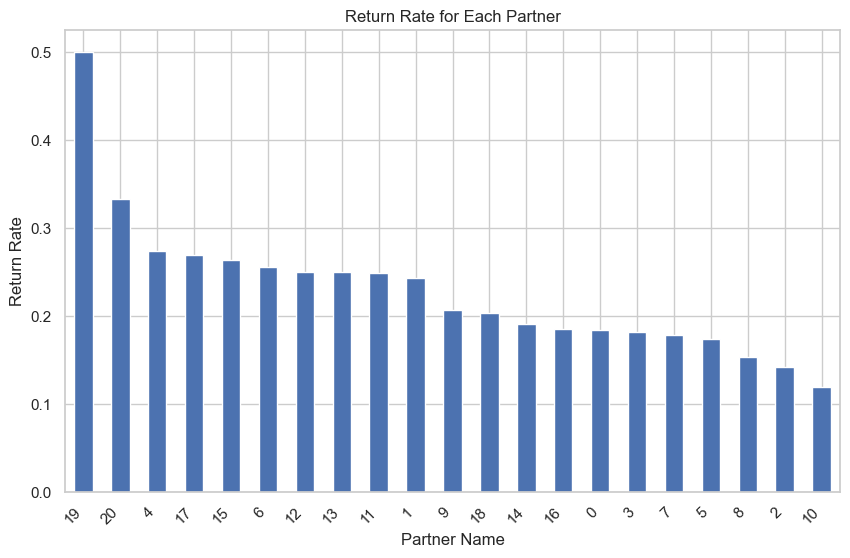

In [523]:
df_final_sorted = df_final.sort_values('return_rate', ascending=False)

df_final_sorted['return_rate'].plot(kind='bar', figsize=(10,6))
plt.title('Return Rate for Each Partner')
plt.ylabel('Return Rate')
plt.xlabel('Partner Name')
plt.xticks(rotation=45, ha='right')  # This rotates x-axis labels for better visibility
plt.show()



In [524]:
df_final.describe()

,total_customers,returning_customers,return_rate
count,21.000000,21.000000,21.000000
mean,678.047619,161.857143,0.229225
std,1317.664201,332.555302,0.080782
min,2.000000,1.000000,0.120000
25%,13.000000,2.000000,0.182692
50%,169.000000,35.000000,0.207101
75%,437.000000,119.000000,0.256212
max,5554.000000,1423.000000,0.500000


- 25% of the operators have a return_rate of 0.185185 or lower, 50% have a return_rate of 0.219780 or lower, and 75% have a return_rate of 0.256203 or lower.

- the average number of total_customers is about 699 and the average return_rate is about 0.22.

- The median (50%) is less than the mean for total_customers and returning_customers, which indicates that these distributions are skewed to the right. That means there are a few operators with a very large number of customers, which pulls the mean up.

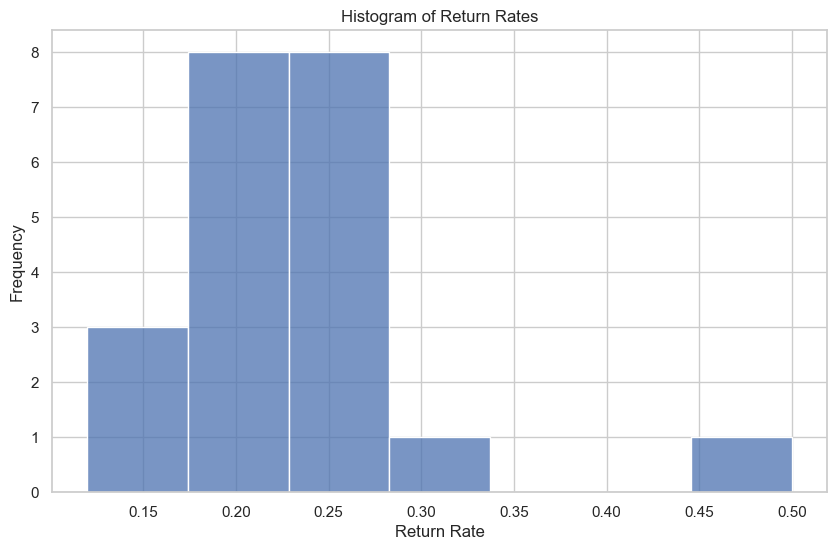

In [525]:
plt.figure(figsize=(10,6))
sns.histplot(df_final['return_rate'], bins=7, kde=False)
plt.title('Histogram of Return Rates')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.show()


In [528]:
df_final.drop('total_customers', axis = 1, inplace = True)

In [529]:
df_final.drop('returning_customers', axis = 1, inplace = True)

In [530]:
df_final.columns = ['operator', 'return_rate']

In [531]:
rfm = rfm.merge(df_final, on='operator')

In [532]:
rfm.index = rfm['operator']

rfm.drop('operator', axis = 1, inplace = True)

rfm

,recency,frequency,monetary,return_rate
operator,,,,
Bond Collective,18,377,30043.75,0.183946
Brain Embassy,18,605,42261.96,0.243437
Coalition Space,75,8,455.00,0.142857
FoundrSpace,18,146,10972.50,0.182692
Luminary,18,785,85116.75,0.274600
M-Dot,23,101,10093.71,0.174603
Mindspace,18,9131,734809.33,0.256212
Nomadworks,19,932,69765.50,0.178679
Platform Coworking,18,16,815.00,0.153846


### Operator Life Time in Days 

In [534]:
#fdf['date'] = pd.to_datetime(fdf['date'])


partner_lifetimes = fdf.groupby('operator_name')['date'].agg(['min', 'max'])
partner_lifetimes['lifetime'] = (partner_lifetimes['max'] - partner_lifetimes['min']).dt.days

# Add 1 day to the 'lifetime' column
partner_lifetimes['lifetime'] = partner_lifetimes['lifetime'] + 1

In [535]:
partner_lifetimes.drop('min', axis = 1, inplace = True)

In [536]:
partner_lifetimes.drop('max', axis = 1, inplace = True)

In [537]:
partner_lifetimes

,lifetime
operator_name,
Bond Collective,91
Brain Embassy,698
Coalition Space,128
FoundrSpace,312
Luminary,403
M-Dot,368
Mindspace,843
Nomadworks,709
Platform Coworking,31


In [538]:
partner_lifetimes = partner_lifetimes.rename_axis('operator')


In [539]:
rfm = rfm.merge(partner_lifetimes, on='operator')

In [540]:
rfm.describe()

,recency,frequency,monetary,return_rate,lifetime
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,27.380952,1080.761905,113664.390952,0.229225,340.904762
std,23.768627,2158.777128,209369.418923,0.080782,261.346112
min,18.000000,3.000000,395.000000,0.120000,2.000000
25%,18.000000,16.000000,1847.500000,0.182692,128.000000
50%,19.000000,261.000000,29145.760000,0.207101,312.000000
75%,23.000000,785.000000,85116.750000,0.256212,536.000000
max,116.000000,9131.000000,734809.330000,0.500000,843.000000


# Full RFM + Features Analysis

In [541]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary,return_rate,lifetime
0.25,18.0,16.0,1847.50,0.182692,128.0
0.50,19.0,261.0,29145.76,0.207101,312.0
0.75,23.0,785.0,85116.75,0.256212,536.0


In [542]:
quantiles.to_dict()

{'recency': {0.25: 18.0, 0.5: 19.0, 0.75: 23.0},
 'frequency': {0.25: 16.0, 0.5: 261.0, 0.75: 785.0},
 'monetary': {0.25: 1847.5, 0.5: 29145.76, 0.75: 85116.75},
 'return_rate': {0.25: 0.18269230769230768,
  0.5: 0.20710059171597633,
  0.75: 0.25621173928700036},
 'lifetime': {0.25: 128.0, 0.5: 312.0, 0.75: 536.0}}

In [543]:
# Arguments (x = value, p = recency, monetary, frequency, return_rate, lifetime, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary, frequency, return_rate, lifetime, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [544]:
#create rfm segmentation table
rfm_segmentation = rfm
rfm_segmentation['r_quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency',quantiles,))
rfm_segmentation['f_quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfm_segmentation['m_quartile'] = rfm_segmentation['monetary'].apply(FMScore, args=('monetary',quantiles,))
rfm_segmentation['return_quartile'] = rfm_segmentation['return_rate'].apply(FMScore, args=('return_rate',quantiles,))
rfm_segmentation['lifetime_quartile'] = rfm_segmentation['lifetime'].apply(FMScore, args=('lifetime',quantiles,))


In [545]:
rfm_segmentation

,recency,frequency,monetary,return_rate,lifetime,r_quartile,f_quartile,m_quartile,return_quartile,lifetime_quartile
operator,,,,,,,,,,
Bond Collective,18,377,30043.75,0.183946,91,4,3,3,2,1
Brain Embassy,18,605,42261.96,0.243437,698,4,3,3,3,4
Coalition Space,75,8,455.00,0.142857,128,1,1,1,1,1
FoundrSpace,18,146,10972.50,0.182692,312,4,2,2,1,2
Luminary,18,785,85116.75,0.274600,403,4,3,3,4,3
M-Dot,23,101,10093.71,0.174603,368,2,2,2,1,3
Mindspace,18,9131,734809.33,0.256212,843,4,4,4,3,4
Nomadworks,19,932,69765.50,0.178679,709,3,4,3,1,4
Platform Coworking,18,16,815.00,0.153846,31,4,1,1,1,1


In [546]:
rfm_segmentation['RFMScore'] = rfm_segmentation.r_quartile.map(str) \
                            + rfm_segmentation.f_quartile.map(str) \
                            + rfm_segmentation.m_quartile.map(str) \
                            + rfm_segmentation.return_quartile.map(str) \
                            + rfm_segmentation.lifetime_quartile.map(str)


In [547]:
rfm_segmentation.sort_values('RFMScore', ascending=False)

,recency,frequency,monetary,return_rate,lifetime,r_quartile,f_quartile,m_quartile,return_quartile,lifetime_quartile,RFMScore
operator,,,,,,,,,,,
Mindspace,18,9131,734809.33,0.256212,843,4,4,4,3,4,44434
The Malin,18,1365,256210.25,0.249102,422,4,4,4,3,3,44433
The Yard,18,3403,269223.00,0.191410,536,4,4,4,2,3,44423
Werqwise,18,560,116719.50,0.203883,597,4,3,4,2,4,43424
Luminary,18,785,85116.75,0.274600,403,4,3,3,4,3,43343
Brain Embassy,18,605,42261.96,0.243437,698,4,3,3,3,4,43334
Bond Collective,18,377,30043.75,0.183946,91,4,3,3,2,1,43321
FoundrSpace,18,146,10972.50,0.182692,312,4,2,2,1,2,42212
Platform Coworking,18,16,815.00,0.153846,31,4,1,1,1,1,41111


In [548]:
rfm_segmentation_reset.columns


Index(['partner', 'recency', 'frequency', 'monetary', 'return_rate',
       'lifetime', 'r_quartile', 'f_quartile', 'm_quartile', 'return_quartile',
       'lifetime_quartile', 'RFMScore'],
      dtype='object')

In [549]:
rfm_segmentation_reset = rfm_segmentation_reset.rename(columns={'Unnamed: 0': 'operator_name'})


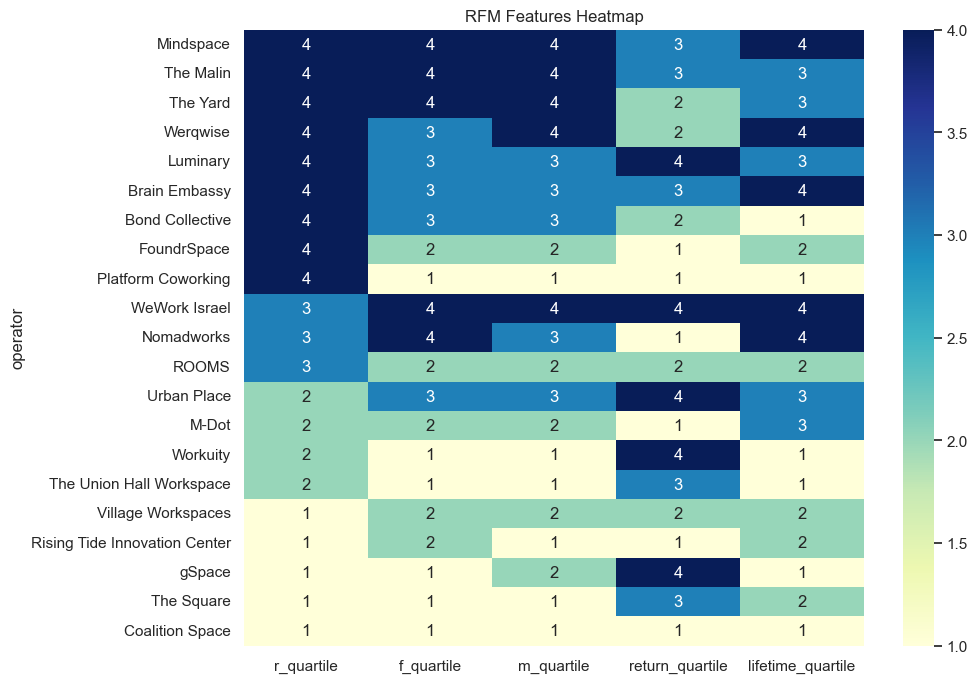

In [550]:
heatmap_data = rfm_segmentation[['r_quartile', 'f_quartile', 'm_quartile', 'return_quartile', 'lifetime_quartile']].sort_values(['r_quartile', 'f_quartile', 'm_quartile', 'return_quartile', 'lifetime_quartile'], ascending=False)
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('RFM Features Heatmap')
plt.show()


- The most successful operator is the one with the lowest recency, highest frequency and monetary value, highest return rate, longest lifetime


-  'Mindspace' is an extremely successful operator. They have recently transacted (recency of 18 days), have the highest frequency of transactions (9131), and have the highest total transaction value (734809.33). Their return rate (0.256212) is high, and they have a long-standing relationship with us (lifetime of 843 days). Moreover, they have high quartile scores, which means they rank near the top among all operators in recency, frequency, and monetary value. What makes them successful could be their regular and high-frequency transactions, leading to high monetary value. Their high return rate suggests successful transactions, and their long-term engagement implies a stable and strong relationship with us.


- WeWork Israel is a highly successful operator. They frequently transact with us (4256) and bring significant monetary value to our business (661162.90). Their return rate is high (0.269231), suggesting successfull returning customers. They have a longstanding relationship with us (694 days), which underscores their reliability. Given their performance, it's clear that WeWork Israel contributes significantly to our business. Their operations and successful strategies could potentially serve as a benchmark for other operators.


- gSpace is a relatively new operator (66 days) with us, doesn't transact as frequently (7) or with as high values (1850.00) as other operators, but when they do transact, they have a high return rate (0.333333). Their overall performance score is relatively low due to lower frequency and monetary value, but the high return rate suggests potential for future success as they continue to transact with us. This operator could benefit from strategies to increase their transaction frequency and monetary value while maintaining their high return rate.

